## scAnalysis of Gerber et.al. dataset

Here we start with the raw matrix produced by featureCount. Raw counts are filtered, transformed, and dimensionality rediction is performed.

In [1]:
file.path(R.home("bin"), "R")

[1] "C:/Users/giovanni/anaconda3/envs/r4-base/lib/R/bin/x64/R"

In [2]:

library(Seurat)
library(sctransform)
library(dplyr)
library(tidyverse)
library(readxl)
library(stringr)
library(HDF5Array)
library(ggplot2)
library(viridis)

library("BiocParallel")
register(SnowParam(4))


Warning message:
"package 'Seurat' was built under R version 4.0.4"
Attaching SeuratObject

Warning message:
"package 'dplyr' was built under R version 4.0.4"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'tidyverse' was built under R version 4.0.5"
Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.1     v stringr 1.4.0
v tidyr   1.1.3     v forcats 0.5.1
v readr   1.4.0     

Warning message:
"package 'tidyr' was built under R version 4.0.4"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'readxl

Read FeatureCounts table

In [4]:
## Get and clean the data
Gerber.Count <- read.table(file = "../../Data/Gerber/bfx1320.AmexG_v6_DD.AmexG_v6_DD.txt", 
                           skip = 1, header = T, 
                           row.names = 1, sep = "\t", stringsAsFactors = F)
Gerber.Count <- Gerber.Count[,-c(1:5)]


In [5]:
## Add time info
Gerber.meta <- read.csv(file = "../../Data/Gerber/GSE106269_metadata.csv", header = T, 
                        stringsAsFactors = T, row.names = 3)

In [6]:
## Keep only SRA.Run Number
colnames(Gerber.Count) <- str_match(colnames(Gerber.Count), "star.(.*?).bam")[,2]
Gerber.meta <- Gerber.meta[colnames(Gerber.Count),]

## Sanity check
sum(!colnames(Gerber.Count) == rownames(Gerber.meta))

[1] 0

In [7]:
## Keep only prrx1:Cre
table(Gerber.meta$GEO.Sample_characteristics_ch1)

prrx1.samples <- Gerber.meta$GEO.Sample_characteristics_ch1 == "cre line: Prrx1:Cre-ER"

Gerber.meta <- Gerber.meta[prrx1.samples,]
Gerber.Count <- Gerber.Count[,prrx1.samples]

table(Gerber.meta$GEO.Sample_source_name_ch1)


    cre line: Col1a2:ER-Cre-ER         cre line: Prrx1:Cre-ER 
                           379                            930 
sc-rna-seq method: Fluidigm C1   sc-rna-seq method: SmartSeq2 
                           197                             82 


forelimb upper arm blastema 11 dpa forelimb upper arm blastema 18 dpa 
                               163                                135 
forelimb upper arm blastema 25 dpa  forelimb upper arm blastema 3 dpa 
                                 0                                108 
forelimb upper arm blastema 38 dpa  forelimb upper arm blastema 5 dpa 
                                 0                                167 
 forelimb upper arm blastema 8 dpa       forelimb upper arm uninjured 
                               121                                108 
 forelimb upper arm uninjured 1apa  forelimb upper arm uninjured 3mpa 
                                51                                 77 
      Stage 28 forelimb limb field         Stage 40 forelimb limb bud 
                                 0                                  0 
        Stage 44 forelimb limb bud 
                                 0 

In [8]:
## Sanity check
sum(!colnames(Gerber.Count) == rownames(Gerber.meta))


[1] 0

In [9]:
Gerber.meta$GEO.Sample_source_name_ch1 <- 
  fct_recode(Gerber.meta$GEO.Sample_source_name_ch1, 
             Blastema_11dpa = "forelimb upper arm blastema 11 dpa",
             Blastema_18dpa = "forelimb upper arm blastema 18 dpa",
             Blastema_25dpa = "forelimb upper arm blastema 25 dpa",
             Blastema_3dpa = "forelimb upper arm blastema 3 dpa",
             Blastema_38dpa = "forelimb upper arm blastema 38 dpa",
             Blastema_5dpa = "forelimb upper arm blastema 5 dpa",
             Blastema_8dpa = "forelimb upper arm blastema 8 dpa",
             Uninjured_0dpa = "forelimb upper arm uninjured",
             Uninjured_1apa = "forelimb upper arm uninjured 1apa",
             Uninjured_3mpa = "forelimb upper arm uninjured 3mpa",
             LimbField_Stg28 = "Stage 28 forelimb limb field",
             LimbBud_Stg40 = "Stage 40 forelimb limb bud",
             LimbBud_Stg44 = "Stage 44 forelimb limb bud")

In [10]:
## Sanity check
sum(!colnames(Gerber.Count) == rownames(Gerber.meta))

[1] 0

Creat Seurat Object

In [11]:
GerberAxo <- CreateSeuratObject(counts = Gerber.Count, project = "Gerber")
# ScAxo <- ScAxo[symbol2ID$gene_id,]

GerberAxo@meta.data$Stage <- Gerber.meta[rownames(GerberAxo@meta.data),"GEO.Sample_source_name_ch1"]
GerberAxo@meta.data$Assay <- "Smart_Seq2"
head(GerberAxo@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,Stage,Assay
,<fct>,<dbl>,<int>,<fct>,<chr>
SRR7368219,Gerber,535004,7300,Blastema_5dpa,Smart_Seq2
SRR7368220,Gerber,1099788,8178,Blastema_5dpa,Smart_Seq2
SRR7368221,Gerber,1223238,3738,Blastema_5dpa,Smart_Seq2
SRR7368222,Gerber,944142,5223,Blastema_5dpa,Smart_Seq2
SRR7368223,Gerber,1298689,3903,Blastema_5dpa,Smart_Seq2
SRR7368224,Gerber,1396329,8396,Blastema_5dpa,Smart_Seq2


**QC**

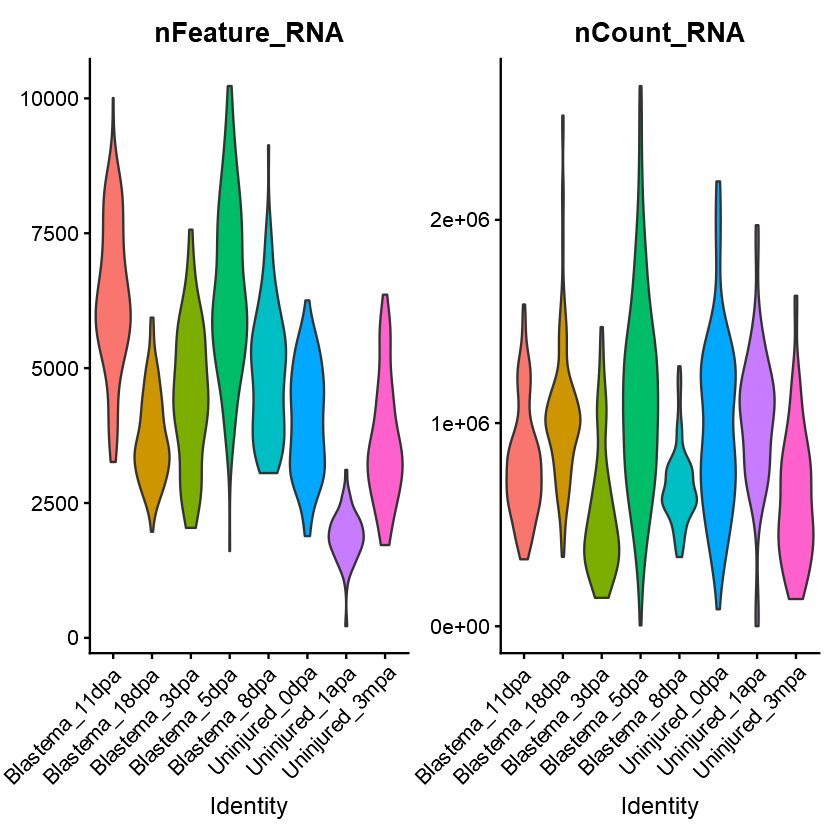

In [12]:
VlnPlot(GerberAxo, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2, 
        pt.size = 0, group.by = "Stage")

In [13]:
GerberAxo <- subset(GerberAxo, 
                    subset = nFeature_RNA > 250)

In [14]:
GerberAxo

An object of class Seurat 
99218 features across 929 samples within 1 assay 
Active assay: RNA (99218 features, 0 variable features)

In [15]:
table(GerberAxo$orig.ident)


Gerber 
   929 

Process and normalise counts

In [16]:
GerberAxo <- SCTransform(GerberAxo, 
                     vars.to.regress = c("nCount_RNA"), 
                     verbose = TRUE)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 28066 by 929

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 929 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted)

  |======================================================================| 100%


There are 1 estimated thetas smaller than 1e-07 - will be set to 1e-07

Found 2 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 28066 genes



  |======================================================================| 100%


Computing corrected count matrix for 28066 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 56.91845 secs

Determine variable features

Place corrected count matrix in counts slot

Regressing out nCount_RNA

Centering data matrix

Set default assay to SCT



Dimensionality reduction

In [17]:
GerberAxo <- RunPCA(GerberAxo, features = VariableFeatures(object = GerberAxo))

dims.use = 1:30

PC_ 1 
Positive:  AMEX60DD051344, AMEX60DD047546, AMEX60DD003755, AMEX60DD026748, AMEX60DD043997, AMEX60DD007589, AMEX60DD009107, AMEX60DD009937, AMEX60DD055459, AMEX60DD054256 
	   AMEX60DD055538, AMEX60DD023969, AMEX60DD017974, AMEX60DD050718, AMEX60DD027994, AMEX60DD055540, ERCC-00096, ERCC-00002, AMEX60DD010491, ERCC-00130 
	   ERCC-00113, AMEX60DD043179, ERCC-00171, ERCC-00136, AMEX60DD030096, AMEX60DD030520, AMEX60DD008854, AMEX60DD022398, AMEX60DD034687, AMEX60DD034289 
Negative:  AMEX60DD052120, AMEX60DD001756, AMEX60DD042749, AMEX60DD050822, AMEX60DDU001002594, AMEX60DD015718, AMEX60DD022490, AMEX60DD031113, AMEX60DDU001007334, AMEX60DD031316 
	   AMEX60DD049488, AMEX60DD023999, AMEX60DD029607, AMEX60DD018809, AMEX60DD016524, AMEX60DD028505, AMEX60DD049490, AMEX60DD043904, AMEX60DD043905, AMEX60DD029426 
	   AMEX60DD007430, AMEX60DD020992, AMEX60DD033568, AMEX60DD031927, AMEX60DD040292, AMEX60DD027352, AMEX60DD056215, AMEX60DD003880, AMEX60DD040413, AMEX60DD015436 
PC_ 2 
Posi

In [18]:
GerberAxo <- RunUMAP(GerberAxo, dims = dims.use)
GerberAxo <- FindNeighbors(GerberAxo, dims = dims.use)
GerberAxo <- FindClusters(GerberAxo, resolution = 0.4)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
16:15:38 UMAP embedding parameters a = 0.9922 b = 1.112

16:15:38 Read 929 rows and found 30 numeric columns

16:15:38 Using Annoy for neighbor search, n_neighbors = 30

16:15:38 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:15:40 Writing NN index file to temp file C:\Users\giovanni\AppData\Local\Temp\RtmpyWsVwp\file72884b927967

16:15:40 Searching Annoy index using 1 thread, search_k = 3000

16:15:41 Annoy recall = 100%

16:15:42 Commencing smooth kNN distance calibration using 1 th

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 929
Number of edges: 33507

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8358
Number of communities: 6
Elapsed time: 0 seconds


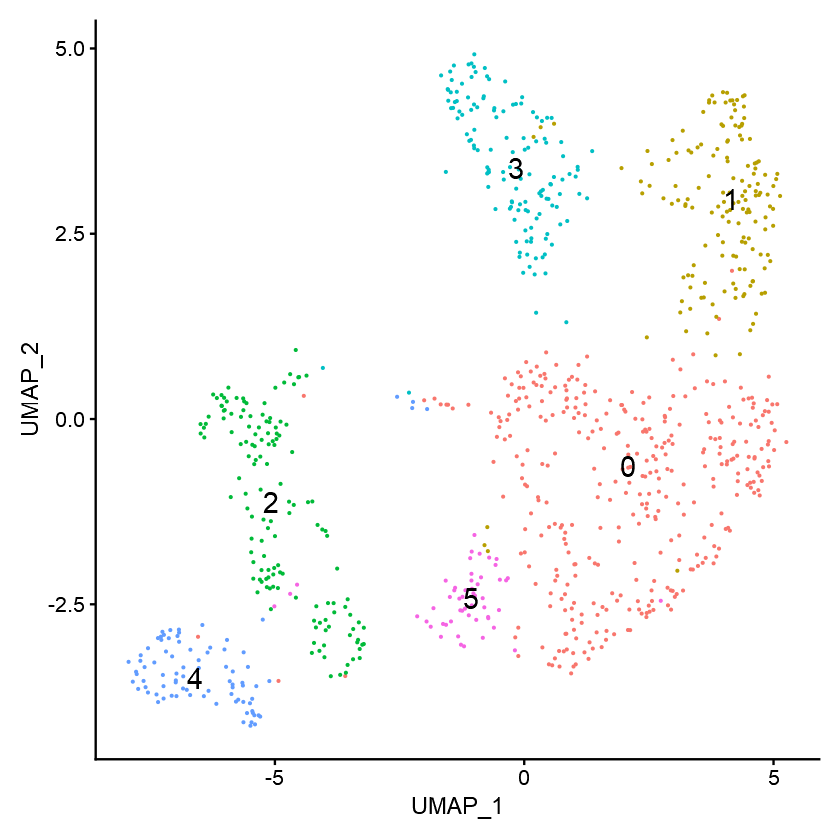

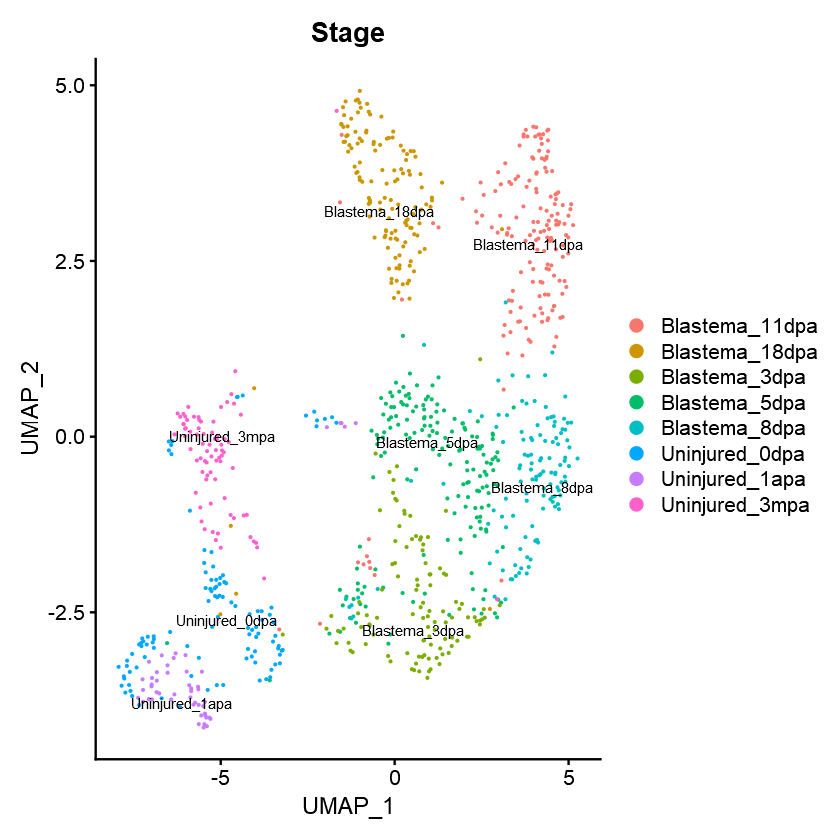

In [19]:
DimPlot(GerberAxo, reduction = "umap", pt.size = 0.1, label = T, label.size = 6) + NoLegend()

DimPlot(GerberAxo, reduction = "umap", pt.size = 0.1, label = T, 
        label.size = 3, group.by = "Stage", repel = T)

In [20]:
saveRDS(GerberAxo, file = "Gerber_Seurat.rds")

**Subset to Blastema only, and no early time point**

In [28]:
GerberAxo <- subset(GerberAxo, subset = Stage %in% c("Blastema_8dpa", 
                                                     "Blastema_11dpa", 
                                                     "Blastema_18dpa"))

In [30]:
table(GerberAxo$Stage)


 Blastema_11dpa  Blastema_18dpa  Blastema_25dpa   Blastema_3dpa  Blastema_38dpa 
            163             135               0               0               0 
  Blastema_5dpa   Blastema_8dpa  Uninjured_0dpa  Uninjured_1apa  Uninjured_3mpa 
              0             121               0               0               0 
LimbField_Stg28   LimbBud_Stg40   LimbBud_Stg44 
              0               0               0 

Process and normalise counts

In [31]:
GerberAxo <- SCTransform(GerberAxo, 
                     vars.to.regress = c("nCount_RNA"), 
                     verbose = TRUE)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 22300 by 419

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 419 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"Si è prodotto un NaN"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted)

  |======================================================================| 100%


Found 8 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 22300 genes



  |======================================================================| 100%


Computing corrected count matrix for 22300 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 18.31684 secs

Determine variable features

Place corrected count matrix in counts slot

Regressing out nCount_RNA

Centering data matrix

Set default assay to SCT



Dimensionality reduction

In [32]:
GerberAxo <- RunPCA(GerberAxo, features = VariableFeatures(object = GerberAxo))

dims.use = 1:30

PC_ 1 
Positive:  AMEX60DD028252, AMEX60DD015718, AMEX60DD013399, AMEX60DD025622, AMEX60DD015130, AMEX60DD014742, AMEX60DD017593, AMEX60DD043188, AMEX60DD021058, AMEX60DDU001004733 
	   AMEX60DD029611, AMEX60DD053991, AMEX60DD049727, AMEX60DD007318, AMEX60DD007586, AMEX60DD017351, AMEX60DD028369, AMEX60DD026125, AMEX60DD020484, AMEX60DD003880 
	   AMEX60DD030096, AMEX60DD049175, AMEX60DD022490, AMEX60DD007260, AMEX60DD023999, AMEX60DD053448, AMEX60DD030520, AMEX60DD017974, AMEX60DD001823, AMEX60DD032706 
Negative:  ERCC-00074, ERCC-00004, ERCC-00046, AY659991.25, AY659991.21, AY659991.45, AY659991.50, AMEX60DD029426, AMEX60DD005921, AMEX60DD033568 
	   ERCC-00043, AMEX60DD010831, AMEX60DD018809, AMEX60DD004178, AMEX60DD026961, AMEX60DD006010, AMEX60DD048972, AMEX60DD042501, AMEX60DD002658, AMEX60DD014606 
	   AMEX60DD048819, AMEX60DD028164, AMEX60DD034258, AMEX60DD019413, AMEX60DD031033, AMEX60DD010100, AMEX60DD053280, AMEX60DD016515, AMEX60DD043470, AMEX60DD028631 
PC_ 2 
Positive:  A

In [33]:
GerberAxo <- RunUMAP(GerberAxo, dims = dims.use)
GerberAxo <- FindNeighbors(GerberAxo, dims = dims.use)
GerberAxo <- FindClusters(GerberAxo, resolution = 0.4)

10:55:06 UMAP embedding parameters a = 0.9922 b = 1.112

10:55:06 Read 419 rows and found 30 numeric columns

10:55:06 Using Annoy for neighbor search, n_neighbors = 30

10:55:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:55:06 Writing NN index file to temp file C:\Users\giovanni\AppData\Local\Temp\RtmpiyQYcr\file8070149a14b1

10:55:06 Searching Annoy index using 1 thread, search_k = 3000

10:55:06 Annoy recall = 100%

10:55:07 Commencing smooth kNN distance calibration using 1 thread

10:55:08 Initializing from normalized Laplacian + noise

10:55:08 Commencing optimization for 500 epochs, with 16368 positive edges

10:55:10 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 419
Number of edges: 18839

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7790
Number of communities: 4
Elapsed time: 0 seconds


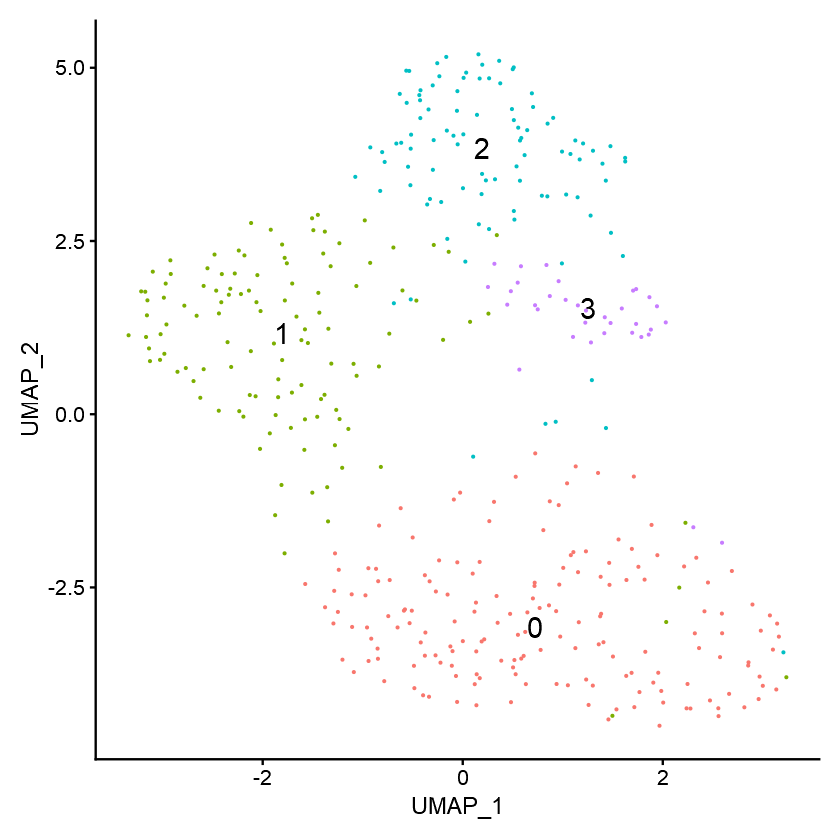

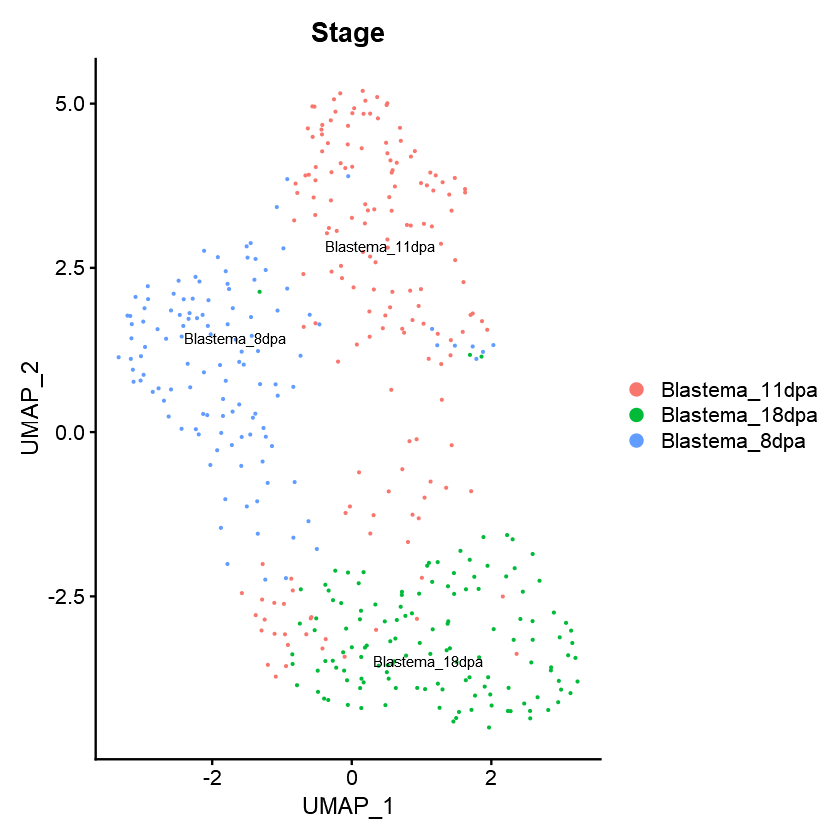

In [34]:
DimPlot(GerberAxo, reduction = "umap", pt.size = 0.1, label = T, label.size = 6) + NoLegend()

DimPlot(GerberAxo, reduction = "umap", pt.size = 0.1, label = T, 
        label.size = 3, group.by = "Stage", repel = T)

In [35]:
saveRDS(GerberAxo, file = "Gerber_Seurat_NewAnno_GeneID_prrx1_NoEarly.rds")